In [1]:
from time import perf_counter
from pathlib import Path

from src.convolutions import naive_2d_convolve, numpy_2d_convolve
from src.utils import gaussian_2d_kernel, run_and_time_convolution

import cv2
import numpy as np
from tifffile import imread
from matplotlib import pyplot as plt
from scipy.ndimage import convolve as scipy_convolve

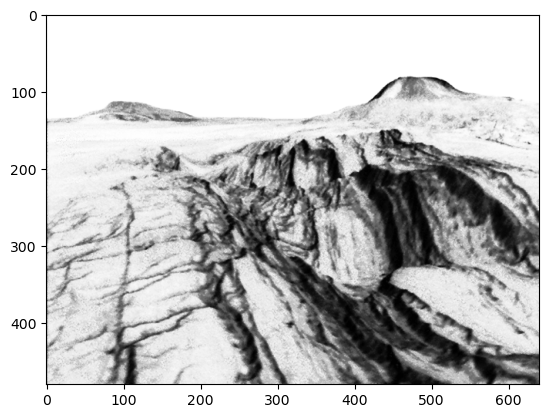

In [2]:
image_path = Path('../test_images/venus1.tif')
image = imread(image_path)
plt.imshow(image, cmap='gray')

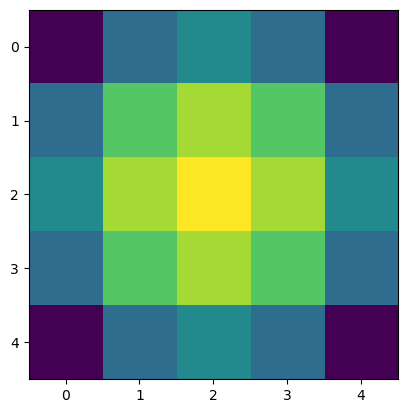

In [3]:
kernel = gaussian_2d_kernel(size=5, sigma=5.0)
plt.imshow(kernel) # Because it looks cool

In [9]:
naive_2d_time, naive_2d_convolution = run_and_time_convolution(naive_2d_convolve, image, kernel)
print(f'Naive convolution algorithm finished in {naive_2d_time} seconds')

numpy_2d_time, naive_2d_convolution = run_and_time_convolution(numpy_2d_convolve, image, kernel)
print(f'Numpy convolution algorithm finished in {numpy_2d_time} seconds')

Naive convolution algorithm finished in 2.37995375005994 seconds
Numpy convolution algorithm finished in 0.01856295799370855 seconds


That's roughly a 100x decrease in compute time. Even though my algorithm is purposefully convoluted (for the sake of learning) it is still far faster than any non-vectorized implementation.

In [10]:
scipy_2d_time, scipy_2d_convolution = run_and_time_convolution(scipy_convolve, image, kernel)
print(f'Scipy convolution algorithm finished in {scipy_2d_time} seconds')

Scipy convolution algorithm finished in 0.011655332986265421 seconds


Ok... well, it's not like I was really trying very hard to make mine blazingly fast...